In [1]:
%%time

%cd "~/lab/NB10422645"

from src.surrogate.algorithms import ssifl2
from src.surrogate.models import RandomForestRegression, SupportVectorRegression, FeedForwardNNRegression
from sklearn.preprocessing import MinMaxScaler
from src.surrogate.tools.matlab import idx_target_sim_func


/home/ggarrett/lab/NB10422645


/home/ggarrett/anaconda3/envs/sigh/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


CPU times: user 1.22 s, sys: 367 ms, total: 1.58 s
Wall time: 1.04 s


In [36]:
from scipy.io import loadmat
import skopt
from tqdm import tqdm_notebook as tqdm

train = loadmat("simulation/data/rs_bicycle/idoe/rs_bicycle_UG_N3_S15.mat") 
test = loadmat("simulation/data/rs_bicycle/idoe/rs_bicycle_UG_N3_S10.mat")


f1_sim=idx_target_sim_func(0, tag="f1")
f2_sim=idx_target_sim_func(1, tag="f2")
f3_sim=idx_target_sim_func(2, tag="f3")


class TqdmSkopt(object):
    def __init__(self, **kwargs):
        self._bar = tqdm(**kwargs)

    def __call__(self, res):
        self._bar.update()

    def close(self):
        self._bar.close()
        self._bar.clear()
        
def evaluate(current_model, ep, validation_data):
    y_pred = current_model.predict(validation_data[0])
    epsilon = (np.max(validation_data[1]) - np.min(validation_data[1])) * ep
    abs_error = np.abs(y_pred - validation_data[1])
    Pr = len(abs_error[abs_error <= epsilon])/len(abs_error)
    print(f"Pr(|f(x)-f_s(x)| <= epsilon) = {Pr}")


def train_rs_bicycle_model(idx):
    f_idx = idx
    scaler=MinMaxScaler(feature_range=(0,10))
    training_data = (train["X"], scaler.fit_transform(train["F"][:,f_idx].reshape(-1,1)).flatten())
    validation_data = (test["X"], scaler.transform(test["F"][:,f_idx].reshape(-1,1)).flatten())
    t_mod = SupportVectorRegression()
    hpopt_space = t_mod.space
    @skopt.utils.use_named_args(hpopt_space)
    def objective(**params):
        t_mod.reset_model()
        static_params = {"training_data": training_data, "validation_data": validation_data,
                         "Xdim": len(training_data[0][0]), "fdim": 1}
        t_mod.static_params = static_params
        t_mod.hyper_params = params
        t_mod.fit(*training_data)
        return -t_mod.score(*validation_data)

    n_calls=15
    total=15
    progress = TqdmSkopt(total=total, desc="Model HpOpt", leave=False)
    results = skopt.forest_minimize(objective, hpopt_space, verbose=False, n_calls=n_calls,
                                    callback=[progress])
    t_mod.reset_model()
    static_params = {"training_data": training_data, "validation_data": validation_data,
                     "Xdim": len(training_data[0][0]), "fdim": 1}
    t_mod.static_params = static_params
    t_mod.hyper_params = t_mod.hyper_params_x(results.x)
    current_model = t_mod
    current_model.fit(*training_data)
    return current_model, scaler, training_data, validation_data
    

In [149]:
# f1_model, s1, t1, v1 = train_rs_bicycle_model(0)
evaluate(f1_model, 0.10, v1)
evaluate(f1_model, 0.05, v1)
evaluate(f1_model, 0.01, v1)

Pr(|f(x)-f_s(x)| <= epsilon) = 1.0
Pr(|f(x)-f_s(x)| <= epsilon) = 0.999
Pr(|f(x)-f_s(x)| <= epsilon) = 0.726


In [289]:
# f2_model, s2, t2, v2 = train_rs_bicycle_model(1)
evaluate(f2_model, 0.10, v2)
evaluate(f2_model, 0.05, v2)
evaluate(f2_model, 0.01, v2)

Pr(|f(x)-f_s(x)| <= epsilon) = 1.0
Pr(|f(x)-f_s(x)| <= epsilon) = 0.999
Pr(|f(x)-f_s(x)| <= epsilon) = 0.68


In [290]:
# f3_model, s3, t3, v3 = train_rs_bicycle_model(2)
# evaluate(f3_model, 0.1, v3)
evaluate(f3_model, 0.10, v3)
evaluate(f3_model, 0.05, v3)
evaluate(f3_model, 0.01, v3)

Pr(|f(x)-f_s(x)| <= epsilon) = 0.995
Pr(|f(x)-f_s(x)| <= epsilon) = 0.954
Pr(|f(x)-f_s(x)| <= epsilon) = 0.65


In [57]:
def make_function_from_mod(model, scaler):
    def f(*X):
        return scaler.inverse_transform(model.predict(np.array([X])).reshape(-1,1)).flatten()[0]
    return f

def make_function_from_sim(sim_f):
    def f(*X):
        return sim_f(*np.array([X]).T)[0]
    return f

In [79]:
f1_s = make_function_from_mod(f1_model, s1)
f2_s = make_function_from_mod(f2_model, s2)
f3_s = make_function_from_mod(f3_model, s3)

f1   = make_function_from_sim(f1_sim)
f2   = make_function_from_sim(f2_sim)
f3   = make_function_from_sim(f3_sim)


X_test = [0.1,0.9,0.1]

for pair in [(f1,f1_s),(f2,f2_s),(f3,f3_s)]:
    print(np.round(np.array([pair[0](*X_test), pair[1](*X_test)]),4))

[0.8931 0.8895]


[0.1556 0.1543]


[181.7331 181.176 ]


In [ ]:
# f_ = [f1,f2,f3]

# f_[0]

In [64]:
%%timeit

f1(*X_test)

593 ms ± 69.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [63]:
%%timeit

f1_s(*X_test)

207 µs ± 44.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [267]:
import pygmo as pg
from src.optimisation import GlobalOptimisation, OptimisationRoutine, PopulationManager, LocalOptimisation


class BicycleProblemS1:
    def __init__(self, f, bf=None):
        self.f = f
        self.bf = bf
        
    def fitness(self, x):
        obj = -self.f[1](*x)
        ce1 = self.f[0](*x) - 1.0
        ci1 = 150 - self.f[2](*x)
        return [obj, ce1, ci1]
        
    def get_bounds(self):
        return ([0.]*3, [1.]*3)
    
    def get_nic(self):
        return 1

    def get_nec(self):
        return 1
    
class BicycleProblemS2:
    def __init__(self, f, bf=None):
        self.f = f
        self.bf = bf
        
    def fitness(self, x):
        obj = self.f[1](*x)
        ce1 = self.f[0](*x) - 1.0
        ci1 = 150 - self.f[2](*x)
        return [obj, ce1, ci1]
        
    def get_bounds(self):
        return ([0.]*3, [1.]*3)
    
    def get_nic(self):
        return 1

    def get_nec(self):
        return 1
    
class BicycleProblemS3:
    def __init__(self, f, bf=None):
        self.f = f
        self.bf = bf
        
    def fitness(self, x):
        obj = -self.f[0](*x)
        ce1 = 0.1 - self.f[1](*x)
        ci1 = 150 - self.f[2](*x)
        return [obj, ce1, ci1]
        
    def get_bounds(self):
        return ([0.]*3, [1.]*3)
    
    def get_nic(self):
        return 1

    def get_nec(self):
        return 1
    
# class BicycleProblemS2:
#     def __init__(self, f, bf=None):
#         self.f = f
#         self.bf = bf
        
#     def fitness(self, x):
#         obj = -self.f[1](*x)
#         ce1 = self.f[0](*x) - 1.0
#         ci1 = 200 - self.f[2](*x)
#         return [obj, ce1, ci1]
        
#     def get_bounds(self):
#         return ([0.]*3, [1.]*3)
    
#     def get_nic(self):
#         return 1

#     def get_nec(self):
#         return 1
    
    
#     def gradient(self, x):
#         return pg.estimate_gradient_h(lambda x: self.fitness(x), x)
    
    
surrogate_problemS1 = pg.problem(BicycleProblemS1([f1_s, f2_s, f3_s]))
surrogate_problemS2 = pg.problem(BicycleProblemS2([f1_s, f2_s, f3_s]))
surrogate_problemS3 = pg.problem(BicycleProblemS3([f1_s, f2_s, f3_s]))

simulated_problemS1 = pg.problem(BicycleProblemS1([f1, f2, f3], [f1_sim, f2_sim, f3_sim]))
simulated_problemS2 = pg.problem(BicycleProblemS2([f1, f2, f3], [f1_sim, f2_sim, f3_sim]))
simulated_problemS3 = pg.problem(BicycleProblemS3([f1, f2, f3], [f1_sim, f2_sim, f3_sim]))

class bfe_sim:
    
    def __init__(self):
        pass
        
    def __call__(self, prob, dvs):
        print(dvs.shape)
        return np.hstack([np.array(_bf(dvs.reshape(-1,3))).reshape(-1,1) for _bf in prob.bf]).flatten()
        

# pop_surrogate = pg.population(surrogate_problem, 100)
# pop_simulated = pg.population(simulated_problem, 5, pg.bfe(bfe_sim()))

routine = [
    GlobalOptimisation.gaco(gen=20),
    LocalOptimisation.compass(300)
]


# opt1 = OptimisationRoutine.from_list_algos(pop_surrogate, routine, verbosity=2)
# print(np.round(opt1.champion_x, 4))
# print(np.round(opt1.champion_f, 4))

In [143]:
# opt1 = OptimisationRoutine.from_list_algos(pop_surrogate, routine, verbosity=2)
# print(np.round(opt1.champion_x, 4))
# print(np.round(opt1.champion_f, 4))

[0.7742 0.0535 0.4692]
[ -0.1509   0.     -28.4374]


In [145]:
# opt1 = OptimisationRoutine.from_list_algos(pop_surrogate, routine, verbosity=2)
# print(np.round(opt1.champion_x,4))
# print(np.round(opt1.champion_f, 4))

[0.7635 0.066  0.4498]
[ -0.1599  -0.     -33.0394]


In [254]:
# opt2_hist_X = []
# opt2_hist_f = []

for i in range(100):
    print(f"{i+1}/100") if i%10==0 else False
    opt2 = OptimisationRoutine.from_list_algos( pg.population(surrogate_problemS2, 100), routine, verbosity=2)
    opt2_hist_X.append(opt2.champion_x)
    opt2_hist_f.append(opt2.champion_f) 

1/500
2/500
3/500
4/500
5/500
6/500
7/500
8/500
9/500
10/500
11/500
12/500
13/500
14/500
15/500
16/500
17/500
18/500
19/500
20/500
21/500
22/500
23/500
24/500
25/500
26/500
27/500
28/500
29/500
30/500
31/500
32/500
33/500
34/500
35/500
36/500
37/500
38/500
39/500
40/500
41/500
42/500
43/500
44/500
45/500
46/500
47/500
48/500
49/500
50/500
51/500
52/500
53/500
54/500
55/500
56/500
57/500
58/500
59/500
60/500
61/500
62/500
63/500
64/500
65/500
66/500
67/500
68/500
69/500
70/500
71/500
72/500
73/500
74/500
75/500
76/500
77/500
78/500
79/500
80/500
81/500
82/500
83/500
84/500
85/500
86/500
87/500
88/500
89/500
90/500
91/500
92/500
93/500
94/500
95/500
96/500
97/500
98/500
99/500
100/500


In [268]:
opt3_hist_X = []
opt3_hist_f = []

for i in range(100):
    print(f"{i+1}/100") if i%10==0 else False
    opt3 = OptimisationRoutine.from_list_algos( pg.population(surrogate_problemS3, 100), routine, verbosity=2)
    opt3_hist_X.append(opt3.champion_x)
    opt3_hist_f.append(opt3.champion_f) 

1/500
51/500


In [253]:
# opt2_hist_X = []
# opt2_hist_f = []

for i in range(100):
    print(f"{i+1}/100") if i%10==0 else False
    opt1 = OptimisationRoutine.from_list_algos( pg.population(surrogate_problemS1, 100), routine, verbosity=2)
    opt1_hist_X.append(opt1.champion_x)
    opt1_hist_f.append(opt1.champion_f)    

1/100
2/100
3/100
4/100
5/100
6/100
7/100
8/100
9/100
10/100
11/100
12/100
13/100
14/100
15/100
16/100
17/100
18/100
19/100
20/100
21/100
22/100
23/100
24/100
25/100
26/100
27/100
28/100
29/100
30/100
31/100
32/100
33/100
34/100
35/100
36/100
37/100
38/100
39/100
40/100
41/100
42/100
43/100
44/100
45/100
46/100
47/100
48/100
49/100
50/100
51/100
52/100
53/100
54/100
55/100
56/100
57/100
58/100
59/100
60/100
61/100
62/100
63/100
64/100
65/100
66/100
67/100
68/100
69/100
70/100
71/100
72/100
73/100
74/100
75/100
76/100
77/100
78/100
79/100
80/100
81/100
82/100
83/100
84/100
85/100
86/100
87/100
88/100
89/100
90/100
91/100
92/100
93/100
94/100
95/100
96/100
97/100
98/100
99/100
100/100


In [291]:

X_S1 = np.array(opt1_hist_X)
X_S2 = np.array(opt2_hist_X)
X_S3 = np.array(opt3_hist_X)
X_all = np.array(opt1_hist_X+opt2_hist_X+opt3_hist_X)

f_S1 = np.array(opt1_hist_f)
f_S2 = np.array(opt2_hist_f)
f_S3 = np.array(opt3_hist_f)
f_all = np.array(opt1_hist_f+opt2_hist_f+opt3_hist_f)


score:  -0.424291674127796
[0.04334303 0.96008172 0.08347628] [-0.1461 -0.0911 -0.0244]
[0.0015 0.0227 0.1169]
[0.94500908 0.92485291 0.94238708] [-1.4190e-01 -4.0000e-04 -3.5949e+00]
[1.3000e-03 3.1000e-03 2.3741e+00]
[0.95612184 0.78740861 0.94953863] [-0.1413 -0.     -2.2213]
[5.0000e-04 0.0000e+00 1.3613e+00]
score:  -1.1372347660160609
[0.67499489 0.81453963 0.33974418] [ 0.1335 -0.0196 -3.0041]
[0.0131 0.0152 4.2334]
[0.94310296 0.89250184 0.93945614] [ 1.4200e-01 -1.9000e-03 -2.9939e+00]
[1.3000e-03 3.5000e-03 2.5981e+00]
score:  -15.204204668154876
[0.29239002 0.6130025  0.62359087] [ -0.5387   0.     -67.2239]
[ 0.0426  0.     13.8548]


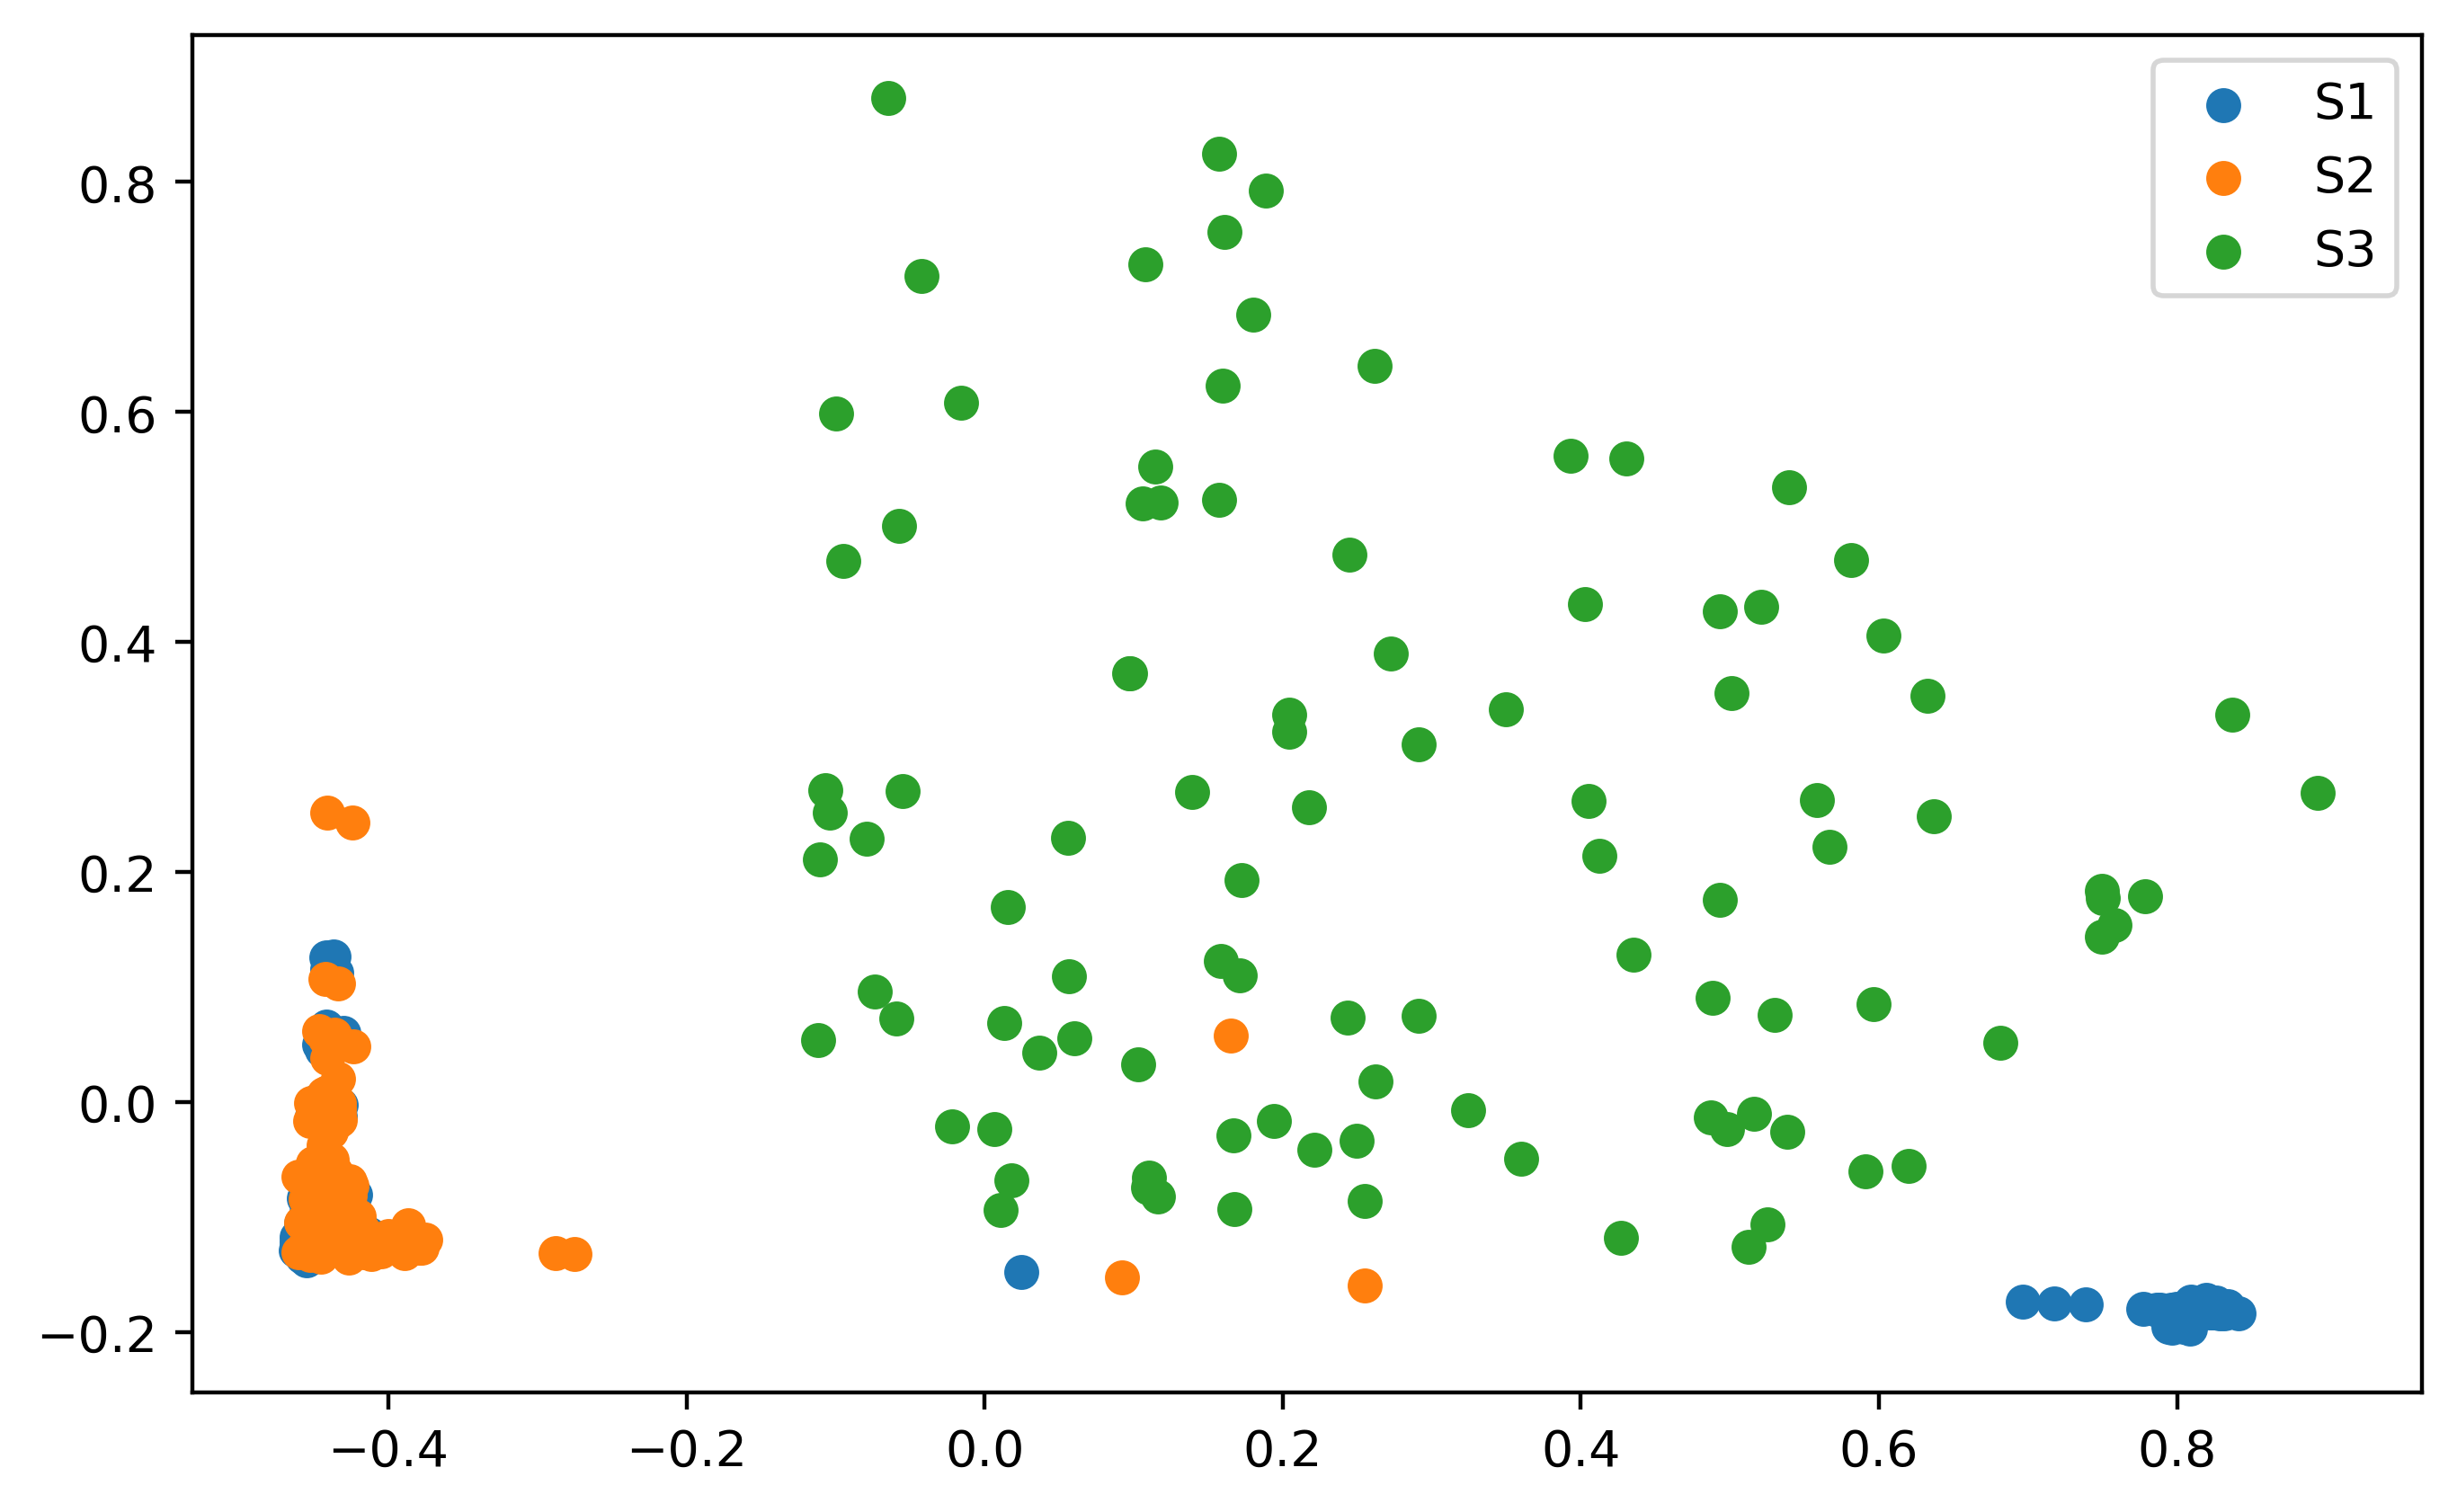

In [304]:


from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

n_c = 4
pca = PCA(n_components=2)
pca_trans = pca.fit(X_all)

def k_means_analysis(n_c, X, f):
    kmeans = KMeans(n_clusters=n_c, random_state=0).fit(X)
    kmeans.labels_
    print("score: ", kmeans.score(X))
    idx = kmeans.labels_

    for i in range(n_c):
        print(np.mean(X[idx==i],axis=0), np.round(np.mean(f[idx==i],axis=0),4))
        print(np.round((np.var(f[idx==i],axis=0)**(1/2)),4))


def pca_2d_plot(X, lab=None):
    import numpy as np
    x2 = pca_trans.transform(X)
    plt.scatter(*x2.T, label=lab)



k_means_analysis(3, X_S1, f_S1)
k_means_analysis(2, X_S2, f_S2)
k_means_analysis(1, X_S3, f_S3)


plt.figure(figsize=(8,5), dpi=400)
pca_2d_plot(X_S1, lab="S1")
pca_2d_plot(X_S2, lab="S2")
pca_2d_plot(X_S3, lab="S3")
plt.legend()
plt.savefig("notebooks/test.png")

def pca_joint_2d(X_all,f_all, Xt,ft):
    pca = PCA(n_components=2)
    s_all = np.hstack([X_all,f_all])
    pca_trans = pca.fit(s_all)
    
    s_t = np.hstack([Xt, ft])
    x2 = pca_trans.transform(s_t)
    plt.scatter(*x2.T)

def k_means_joint(n_c, X, f=None):
    s = np.hstack([X,f]) if f is not None else X
    kmeans = KMeans(n_clusters=n_c, random_state=0).fit(s)
    kmeans.labels_
    print("score: ", kmeans.score(s))
    idx = kmeans.labels_
    for i in range(n_c):
        print(np.mean(s[idx==i],axis=0))
    
    
    
# pca_joint_2d(X_all, f_all, X_S1, f_S1)
# pca_joint_2d(X_all, f_all, X_S2, f_S2)

# k_means_joint(4, X_all)
# pca_joint_2d(X_all, f_all, X_S1, f_S1)

# SIFL

## $\epsilon$ and $\delta$ setting for learning.

In [2]:
epsilon = 0.15
delta = 0.2

## $f_1$: Fraction of total cycling track travelled in T.

In [3]:
scaler_f1=MinMaxScaler(feature_range=(0,10))

model_f1_svr = ssifl2(epsilon=epsilon, 
                      delta=delta, 
                      function=f1, 
                      n=2,
                      hpopt=True, 
                      model_handle_cls=SupportVectorRegression, 
                      scaler=scaler_f1,
                      path="./model_f1_svr.sv",
                      hpopt_calls=40)

# absolute error vs sqrd

+------+---------+--------------------+----------+------------------------------+
| iter | s_train | n_s_test < epsilon | n_s_test | Pr(|fsm(x)-f(x)| <= epsilon) |
+------+---------+--------------------+----------+------------------------------+
|  1   |   64    |         9          |    17    |            0.529             |


|  2   |   81    |         13         |    22    |            0.591             |


|  3   |   100   |         16         |    27    |            0.593             |


|  4   |   121   |         18         |    33    |            0.545             |


|  5   |   144   |         21         |    39    |            0.538             |


|  6   |   169   |         26         |    46    |            0.565             |


|  7   |   196   |         25         |    53    |            0.472             |


|  8   |   225   |         30         |    61    |            0.492             |


|  9   |   256   |         32         |    69    |            0.464             |


|  10  |   289   |         33         |    78    |            0.423             |


KeyboardInterrupt: 

## $f_2$: Fraction of T spent in forest.

In [ ]:
scaler_f2=MinMaxScaler(feature_range=(0,1))

model_f2_svr = ssifl2(epsilon=epsilon, 
                      delta=delta, 
                      function=f2, 
                      n=2,
                      hpopt=True, 
                      model_handle_cls=SupportVectorRegression, 
                      scaler=scaler_f2,
                      path="./model_f2_svr.sv")

## $f_3$: Closest distance to passing traffic.

In [ ]:

scaler_f3=MinMaxScaler(feature_range=(0,1))

model_f3_svr = ssifl2(epsilon=epsilon, 
                      delta=delta, 
                      function=f3, 
                      n=2,
                      hpopt=True, 
                      model_handle_cls=SupportVectorRegression, 
                      scaler=scaler_f3,
                      path="./model_f3_svr.sv")

In [8]:
%cd "~/lab/NB10422645"

# from ._base import SurrogateModelBaseRegression
from src.surrogate.meta_models.deeplearning import Trainer3
import torch.nn as nn
import torch
from src.surrogate.meta_models.modules import activation_dict
from src.surrogate.meta_models.modules.fx import RegressionOutput, BasicBlock
from src.dataset import DataSetFX
from src.surrogate.meta_models.deeplearning.util import LutzPrecheltEarlyStopping
import skopt


from torch import nn

class SimpleRectangularNN(nn.Module):

    def __init__(self, model_params):
        Xdim = model_params["x_dim"]
        fdim = model_params["f_dim"]
        activation = model_params["activation"]
        dropout_rate = model_params["dropout_rate"]
        n_hidden_layers = model_params["n_hidden_layers"]
        n_hidden_neurons = model_params["n_hidden_neurons"]
        super().__init__()
        self.fc_in = nn.Sequential(
            *[nn.Linear(Xdim, n_hidden_neurons),
              activation_dict[activation],
              nn.Dropout(dropout_rate),
              nn.BatchNorm1d(n_hidden_neurons)]
        )
        self.fc_center = nn.Sequential(
            *[nn.Linear(n_hidden_neurons, n_hidden_neurons),
              activation_dict[activation],
              nn.Dropout(dropout_rate),
              nn.BatchNorm1d(n_hidden_neurons)
              ] * int(n_hidden_layers - 2)
        )
        self.fc_out = RegressionOutput(n_hidden_neurons, fdim)

    def forward(self, x):
        x = self.fc_in(x)
        x = self.fc_center(x)
        return self.fc_out(x)

/home/ggarrett/lab/NB10422645


In [17]:
from scipy.io import loadmat

train = loadmat("simulation/data/rs_bicycle/idoe/rs_bicycle_UG_N3_S15.mat") 
test = loadmat("simulation/data/rs_bicycle/idoe/rs_bicycle_UG_N3_S10.mat")
x_train = train["X"]
y_train = train["F"][:,1]
x_test = test["X"]
y_test = test["F"][:,1]

# Dataset.
training_dataset = DataSetFX(
        output=y_train.reshape(-1, 1),
        input=x_train.reshape(-1, len(x_train.T)))
validation_dataset = DataSetFX(
        output=y_test.reshape(-1, 1),
        input=x_test.reshape(-1, len(x_train.T)))

In [70]:
import skopt
from src.utils import TQDMSkoptCallable


decision_space = [
    
    # Architecture params.
#     skopt.space.Categorical(["sigmoid", "relu", "leaky_relu"], name="activation"),
    skopt.space.Integer(1,3       ,                           name="n_hidden_layers"),
    skopt.space.Real(*(5e-3, 5e-1),                            name="dropout_rate"),
    skopt.space.Integer(200, 900,                              name="n_hidden_neurons"),
    
    # Training parameters.
    skopt.space.Integer(0,2,             name="early_stopping"),
#     skopt.space.Categorical([50, 100, 200],                    name="batch_size"),
    skopt.space.Real(1e-4, 1e-1, prior="log-uniform",          name="learning_rate")
]

early_stop_list = [
        LutzPrecheltEarlyStopping(5, criteria=(("PQ", 0.75),)),
        LutzPrecheltEarlyStopping(5, criteria=(("PQ", 1.00),)),
        LutzPrecheltEarlyStopping(5, criteria=(("PQ", 1.50),))
    ]
static_params = {

    # Architecture parameters.
    "activation":"leaky_relu",
    "n_hidden_layers":2,
    "n_hidden_neurons":400,
    "dropout_rate":5e-3,
    
    # Training parameters.
    "early_stopping":LutzPrecheltEarlyStopping(5, criteria=(("PQ", 0.9),)),
    "batch_size":50,
    "learning_rate":1e-3,
    "num_epochs":40,
    
}

device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu")

def t2n(t):
    return t.detach().cpu().numpy()
    
def Xn2t(X):
    return torch.tensor(X).to(device).float()

def Fn2t(f):
    return torch.tensor(f.reshape(-1, 1)).to(device).float()

@skopt.utils.use_named_args(decision_space)
def objective(**decided_params):
        
    # Load parameters.
    params = {**static_params, **decided_params}
    
    # Create model.
    model_params={}
    model_params["x_dim"] = 3
    model_params["f_dim"] = 1
    model_params["activation"] = params["activation"]
    model_params["dropout_rate"] = params["dropout_rate"]
    model_params["n_hidden_layers"] = params["n_hidden_layers"]
    model_params["n_hidden_neurons"] = params["n_hidden_neurons"]
    model = SimpleRectangularNN(model_params)
    
    # Training params.
    early_stopping = params["early_stopping"]
    learning_rate  = params["learning_rate"]
    batch_size     = params["batch_size"]
    
    # Set up trainer.
    trainer = Trainer3(
        PATH="meta_models/",
        training_dataset=training_dataset,
        validation_dataset=validation_dataset,
        model=model,
        optimizer=torch.optim.Adam,
        criterion=torch.nn.modules.loss.MSELoss,
        batch_size=batch_size,
        num_epochs=params["num_epochs"],
        learning_rate=params["learning_rate"])
    
    trainer.train(early_stopping=early_stop_list[params["early_stopping"]],
                    save_each_epoch=False,
                    save_final_model=False,
                    plot_jupyter=False,
                    verbose=False)
    
    model.eval()
    with torch.no_grad():
        res=trainer._criterion(
                model(Xn2t(validation_dataset.input)),
                Fn2t(validation_dataset.output)).detach().cpu().numpy()
#         res = model(validation_dataset.input)
    return float(res)

n_calls=150

progress = TQDMSkoptCallable(total=n_calls, desc="Model HpOpt",
                             leave=False)
callback = [progress]

results=skopt.gp_minimize(objective, decision_space, n_calls=n_calls, callback=callback)
# print(results)

/home/ggarrett/anaconda3/envs/sigh/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/ggarrett/anaconda3/envs/sigh/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/ggarrett/anaconda3/envs/sigh/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/ggarrett/anaconda3/envs/sigh/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/ggarrett/anaconda3/envs/sigh/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been

In [65]:
# print(results)
from src.utils import plot_evaluations
import skopt.plots
import matplotlib.pyplot as plt

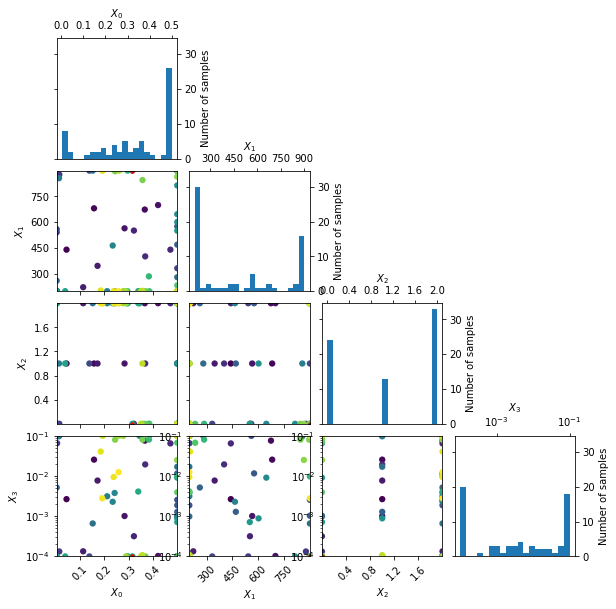

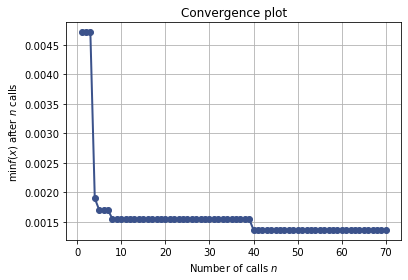

In [68]:
skopt.plots.plot_evaluations(results)
plt.show()
skopt.plots.plot_convergence(results)
plt.show()

In [69]:

print(results.x)

[0.315735021063194, 900, 0, 0.0001]


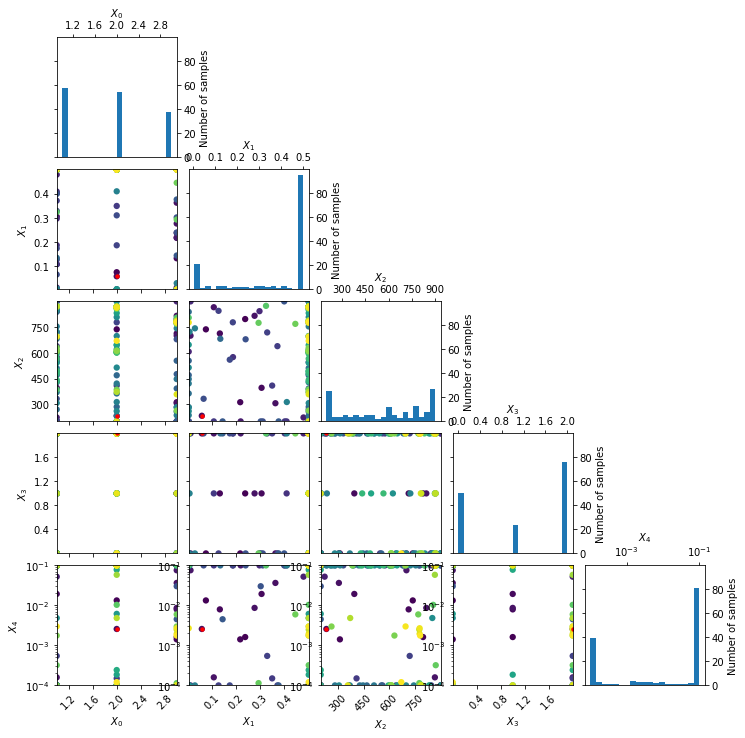

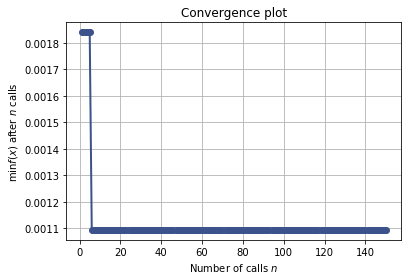

In [71]:
skopt.plots.plot_evaluations(results)
plt.show()
skopt.plots.plot_convergence(results)
plt.show()